In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd drive/MyDrive/Neuromatch

/content/drive/MyDrive/Neuromatch


In [3]:
"""
data manipulatig
"""
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

"""
natural language processing
"""
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
true_data = pd.read_csv('datasets/True.csv')
fake_data = pd.read_csv('datasets/Fake.csv')
true_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
true_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [6]:
fake_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [7]:
# Adding labels
true_data["label"] = np.ones(len(true_data),dtype=int)
fake_data["label"] = np.zeros(len(fake_data),dtype=int)

true_data.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [8]:
data = pd.concat((true_data,fake_data),axis=0)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB
None


In [9]:
data = data.sample(frac=1)
data.head(10)

,title,text,subject,date,label
14914,"EU readies sanctions on Venezuela, approves ar...",BRUSSELS (Reuters) - European Union foreign mi...,worldnews,"November 13, 2017",1
10339,All clear at Rubio campaign office after white...,WASHINGTON (Reuters) - U.S. Republican preside...,politicsNews,"March 15, 2016",1
7754,"GOP Billionaires Panic, Conference Call Begs ...",Republican donors are in a panic over the grow...,News,"March 1, 2016",0
2756,Presidents Bush and Clinton: Be humble in vict...,DALLAS (Reuters) - Former U.S. presidents Geor...,politicsNews,"July 14, 2017",1
17581,ABC NEWS Gets DESTROYED On Twitter For Waiting...,After ABC News broke the General Flynn-Trump s...,left-news,"Dec 1, 2017",0
6440,Back In 2006 Trump DEFENDED Hillary On Her Ir...,One of the biggest talking points being used b...,News,"May 10, 2016",0
1892,The FBI’s Russia Investigation Just Took A Tu...,The FBI is doing something with its probe into...,News,"April 5, 2017",0
900,"After delay, Republicans in Congress prepare t...",WASHINGTON (Reuters) - Republicans in the U.S....,politicsNews,"November 1, 2017",1
14636,VIRAL VIDEO: Bernie Sanders Shoots Hillary The...,This is pretty hysterical and is a reaction du...,politics,"Jan 18, 2016",0
17619,WOW! NASTY LIBERALS ATTACK 9-Year Old Girl Aft...,The Washington Post published an article with ...,left-news,"Nov 21, 2017",0


In [10]:
data["subject"].value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

In [11]:
data = pd.get_dummies(data,columns=["subject"])
data.head()

,title,text,date,label,subject_Government News,subject_Middle-east,subject_News,subject_US_News,subject_left-news,subject_politics,subject_politicsNews,subject_worldnews
14914,"EU readies sanctions on Venezuela, approves ar...",BRUSSELS (Reuters) - European Union foreign mi...,"November 13, 2017",1,0,0,0,0,0,0,0,1
10339,All clear at Rubio campaign office after white...,WASHINGTON (Reuters) - U.S. Republican preside...,"March 15, 2016",1,0,0,0,0,0,0,1,0
7754,"GOP Billionaires Panic, Conference Call Begs ...",Republican donors are in a panic over the grow...,"March 1, 2016",0,0,0,1,0,0,0,0,0
2756,Presidents Bush and Clinton: Be humble in vict...,DALLAS (Reuters) - Former U.S. presidents Geor...,"July 14, 2017",1,0,0,0,0,0,0,1,0
17581,ABC NEWS Gets DESTROYED On Twitter For Waiting...,After ABC News broke the General Flynn-Trump s...,"Dec 1, 2017",0,0,0,0,0,1,0,0,0


In [12]:
data = data.drop("date",axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 14914 to 6025
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   title                    44898 non-null  object
 1   text                     44898 non-null  object
 2   label                    44898 non-null  int64 
 3   subject_Government News  44898 non-null  uint8 
 4   subject_Middle-east      44898 non-null  uint8 
 5   subject_News             44898 non-null  uint8 
 6   subject_US_News          44898 non-null  uint8 
 7   subject_left-news        44898 non-null  uint8 
 8   subject_politics         44898 non-null  uint8 
 9   subject_politicsNews     44898 non-null  uint8 
 10  subject_worldnews        44898 non-null  uint8 
dtypes: int64(1), object(2), uint8(8)
memory usage: 1.7+ MB


In [13]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

True

In [14]:
from nltk.stem.porter import *
new_text = []
pattern = "[^a-zA-Z]"
lemma = nltk.WordNetLemmatizer()
stemmer = PorterStemmer()

for txt in data.text:
    txt = re.sub(pattern, " ", txt)  # Cleaning
    txt = txt.lower()  # Lowering
    txt = nltk.word_tokenize(txt)  # Tokenizing
    txt = [lemma.lemmatize(word) for word in txt]  # Lemmatizing
    txt = [stemmer.stem(word) for word in txt]  # Stemming
    txt = " ".join(txt)
    new_text.append(txt)

new_text[0]

'brussel reuter european union foreign minist approv econom sanction includ an arm embargo on venezuela on monday say region elect last month mar by report irregular had deepen the countri s crisi anxiou not to push caraca ani closer to econom and polit collaps a debt restructur talk begin eu govern held back from target ani individu the bloc instead left name for a later stage to tri to persuad presid nichola maduro to calm the situat everyth we do is aim at seek dialogu between the govern and the opposit to find a democrat and peac solut spain s foreign minist alfonso dasti told report at a meet with hi counterpart where the sanction decis wa made venezuelan opposit leader said last week they would resum effort to hold a dialogu with maduro even though they say he previous use such talk to stall for time instead of implement seriou reform over the weekend maduro had term immin sanction by the bloc a stupid on monday hi govern said the illeg and absurd eu measur were a violat of inter

In [15]:
from nltk.stem.porter import *
new_title = []
lemma = nltk.WordNetLemmatizer()
stemmer = PorterStemmer()

for txt in data.title:
    txt = re.sub(pattern," ",txt) # Cleaning
    txt = txt.lower() # Lowering
    txt = nltk.word_tokenize(txt) # Tokenizing
    txt = [lemma.lemmatize(word) for word in txt] # Lemmatizing
    txt = [stemmer.stem(word) for word in txt]  # Stemming
    txt = " ".join(txt)

    stemmer = PorterStemmer()
    txt = stemmer.stem(txt)

    new_title.append(txt)
new_title[0]

'eu readi sanction on venezuela approv arm embargo'

In [16]:
vectorizer_title = CountVectorizer(stop_words="english",max_features=1000)
vectorizer_text = CountVectorizer(stop_words="english",max_features=4000)

title_matrix = vectorizer_title.fit_transform(new_title).toarray()
text_matrix = vectorizer_text.fit_transform(new_text).toarray()

print("Finished")

Finished


In [17]:
data.drop(["title","text"],axis=1,inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 14914 to 6025
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   label                    44898 non-null  int64
 1   subject_Government News  44898 non-null  uint8
 2   subject_Middle-east      44898 non-null  uint8
 3   subject_News             44898 non-null  uint8
 4   subject_US_News          44898 non-null  uint8
 5   subject_left-news        44898 non-null  uint8
 6   subject_politics         44898 non-null  uint8
 7   subject_politicsNews     44898 non-null  uint8
 8   subject_worldnews        44898 non-null  uint8
dtypes: int64(1), uint8(8)
memory usage: 1.0 MB


In [18]:
data.head()

,label,subject_Government News,subject_Middle-east,subject_News,subject_US_News,subject_left-news,subject_politics,subject_politicsNews,subject_worldnews
14914,1,0,0,0,0,0,0,0,1
10339,1,0,0,0,0,0,0,1,0
7754,0,0,0,1,0,0,0,0,0
2756,1,0,0,0,0,0,0,1,0
17581,0,0,0,0,0,1,0,0,0


In [19]:
print(data.shape)
print(title_matrix.shape)
print(text_matrix.shape)

(44898, 9)
(44898, 1000)
(44898, 4000)


In [20]:
# Creating Y
y = data.label
# Creating X
x = np.concatenate((np.array(data.drop("label",axis=1)),title_matrix,text_matrix),axis=1)

In [21]:
print(x.shape)
print(y.shape)

(44898, 5008)
(44898,)


In [22]:
from sklearn.model_selection import train_test_split

# Train Test Split
X_train,X_test,Y_train,Y_test = train_test_split(x,np.array(y),test_size=0.25,random_state=1)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(33673, 5008)
(11225, 5008)
(33673,)
(11225,)


In [23]:
"""
pytorch
"""

import torch
import torch.nn as nn
"""
visualization tools
"""

import matplotlib.pyplot as plt
import seaborn as sns

"""
train test split
"""
from sklearn.model_selection import train_test_split

In [28]:
print("ANN")
class ANN(nn.Module):

    def __init__(self):

        super(ANN, self).__init__()
        self.linear1 = nn.Linear(5008, 2000)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)  # Add dropout layer

        self.linear2 = nn.Linear(2000, 500)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)

        self.linear3 = nn.Linear(500, 100)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)

        self.linear4 = nn.Linear(100, 20)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.5)

        self.linear5 = nn.Linear(20, 2)


    def forward(self,x):

        out = self.linear1(x)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.linear2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        out = self.linear3(out)
        out = self.relu3(out)
        out = self.dropout3(out)

        out = self.linear4(out)
        out = self.relu4(out)
        out = self.dropout4(out)

        out = self.linear5(out)

        return out


model = ANN()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01 * (0.1 ** (epoch // 10)))
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)


error = nn.CrossEntropyLoss()

ANN


In [32]:
# Converting numpy arrays into pytorch tensors
X_train = torch.Tensor(X_train)

# You must convert it into LongTensor. I did it once
Y_train = torch.Tensor(Y_train).type(torch.LongTensor)

X_test = torch.Tensor(X_test)
Y_test = torch.Tensor(Y_test)

# lambda_l1 = 0.001  # L1 regularization strength
# lambda_l2 = 0.001  # L2 regularization strength

lambda_l1 = 0.0004
lambda_l2 = 0.0004

EPOCHS = 20

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    outs = model(X_train)
    loss = error(outs, Y_train)

    # L1 regularization
    l1_regularization = torch.tensor(0.)  # Initialize L1 regularization term
    l2_regularization = torch.tensor(0.)  # Initialize L2 regularization term

    for param in model.parameters():
        l1_regularization += torch.norm(param, p=1)
        l2_regularization += torch.norm(param, p=2)

    loss += lambda_l1 * l1_regularization + lambda_l2 * l2_regularization

    loss.backward()
    optimizer.step()

    print(f"Loss after iteration {epoch} is {loss}")

Loss after iteration 0 is 9.531394004821777
Loss after iteration 1 is 11.428765296936035
Loss after iteration 2 is 12.522269248962402
Loss after iteration 3 is 13.77283763885498
Loss after iteration 4 is 14.629753112792969
Loss after iteration 5 is 13.797647476196289
Loss after iteration 6 is 11.965505599975586
Loss after iteration 7 is 8.79449462890625
Loss after iteration 8 is 5.370649814605713
Loss after iteration 9 is 5.625834941864014
Loss after iteration 10 is 7.071537017822266
Loss after iteration 11 is 8.009504318237305
Loss after iteration 12 is 8.70723819732666
Loss after iteration 13 is 8.314306259155273
Loss after iteration 14 is 7.683433532714844
Loss after iteration 15 is 5.979784965515137
Loss after iteration 16 is 5.058567523956299
Loss after iteration 17 is 5.358860015869141
Loss after iteration 18 is 5.475438117980957
Loss after iteration 19 is 5.905401229858398


In [33]:
# Importing metrics
from sklearn.metrics import accuracy_score,confusion_matrix


# Prediction
y_head = model(X_test)
print(y_head[0])
# Converting Prediction into labels
y_pred = torch.max(y_head,1)[1]
print(y_pred[0])

# Accuracy score
print("Model accuracy is ",accuracy_score(y_pred,Y_test))

tensor([0.0804, 0.0011], grad_fn=<SelectBackward0>)
tensor(0)
Model accuracy is  0.5280178173719376


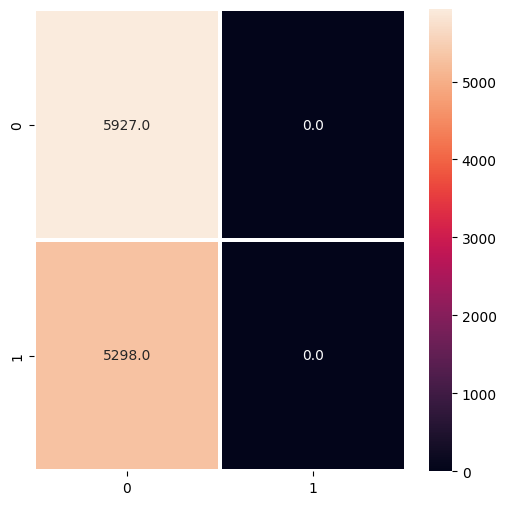

In [34]:
confusion_matrix = confusion_matrix(y_pred=y_pred,y_true=Y_test)

fig,ax = plt.subplots(figsize=(6,6))
sns.heatmap(confusion_matrix,annot=True,fmt="0.1f",linewidths=1.5)
plt.show()